<a href="https://colab.research.google.com/github/deanhoperobertson/Afrikaans-Named-Entity-Recognition/blob/master/Afrikaans%20BiLSTM-CRF%20Model%20(FastText_300D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Afrikaans Bi-LSTM-CRF Model

In [1]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn_crfsuite
!pip install keras==2.2.4

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-scv1d_dz
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-scv1d_dz
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=e043822ce72d8a3455494f04021ad0ef0fefacd2b004a8fe367bcd835af101b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-d5ijfb_w/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
     |████████████████████████████████| 757kB 4.8MB/s 
     |████████████████████████████████| 317kB 3.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
import pandas as pd
import re
import numpy as np
import urllib.request

#keras and tensorflow packages
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,concatenate
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.metrics import crf_accuracy


#evaluation
from sklearn_crfsuite.metrics import flat_classification_report,flat_f1_score,flat_precision_score
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [0]:
def hasNumbers(text):
    if text.isdigit():
        return "1"
    elif re.search(r'\d',text) and re.search(r'\,|\.',text):
        return "1" 
    else:
        if re.search(r'\d', text):
            return(re.sub('\d','D', text))
        else:
            return text

def readstring(filename, meth):
    f = filename.split('\n')
    sentences = []
    sentence = []
    for line in f:
        if line == '\r' or line.startswith('-DOCSTART') or line  =="":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split('\t')
        if meth.lower()=="numbers":
          sentence.append([hasNumbers(splits[0]), splits[-1].strip()])
        else:
          sentence.append([splits[0], splits[-1].strip('\r')])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences

In [0]:
#import data from my github repo
data_url = "https://raw.githubusercontent.com/deanhoperobertson/Named-Enitty-Recognition/master/Data/Afrikaans/Train.txt"
data = urllib.request.urlopen(data_url).read()
data = data.decode('utf-8')

# #preproces the txt file
data = readstring(data,"Numbers")

train_data,test_data=train_test_split(data,train_size=.8, random_state=0)


In [0]:
def reformat_data(data,meth):
  if meth.lower() == "data":
    i=0
  else: i=1
  train = []
  output= []
  for sentence in data:
    words=[]
    for x in sentence:
      words.append(x[i])
    train.append(words)

  for i in train:
    string = ' '.join(i)
    output.append(string)
  return output

def get_max_length(corpus):
  length = []
  for sentence in corpus:
    length.append(len(sentence))
  return int(max(length))

def number_of_tags(corpus):
  tags=[]
  for sentence in corpus:
    for tag in sentence:
      tags.append(tag[1])
  return int(len(list(set(tags))))


MAX_LEN = get_max_length(data)
N_tags = number_of_tags(data)

train = reformat_data(train_data,"data")
test = reformat_data(test_data,"data")

In [0]:
# create a tokenizer
token_word = text.Tokenizer(char_level=False, lower=True, filters="}", oov_token='UNK')
token_word.fit_on_texts(train)

# convert text to sequence of tokens and pad them to ensure equal length vectors 
X_train = sequence.pad_sequences(token_word.texts_to_sequences(train), maxlen=MAX_LEN,padding="post")
X_test = sequence.pad_sequences(token_word.texts_to_sequences(test), maxlen=MAX_LEN,padding="post")

In [0]:
train = reformat_data(train_data,"tags")
test = reformat_data(test_data,"tags")

# create a tokenizer
token_tag = text.Tokenizer(char_level=False, lower=False, filters="}")
token_tag.fit_on_texts(train)

# convert text to sequence of tokens and pad them to ensure equal length vectors 
Y = sequence.pad_sequences(token_tag.texts_to_sequences(train), maxlen=MAX_LEN,padding="post")
# One-Hot encode categorical labels
Y_train = [to_categorical(i, num_classes=N_tags+1) for i in Y]

Y = sequence.pad_sequences(token_tag.texts_to_sequences(test), maxlen=MAX_LEN,padding="post")
# One-Hot encode categorical labels
Y_test = [to_categorical(i, num_classes=N_tags+1) for i in Y]

#add padding 
token_tag.index_word[0]="PAD"
sub_label = list(token_tag.index_word.values())
sub_label.remove('OUT')
sub_label.remove('PAD')

## Adding Embeddings

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# import fasttext
# import fasttext.util
# ft = fasttext.load_model('cc.en.300.bin')
# ft.get_dimension()

# fasttext.util.reduce_model(ft, 100)
# ft.get_dimension()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
#root_path = "/content/drive/My Drive/Wiki.af.300.vec"
root_path = "/content/drive/My Drive/wiki.af.vec"

EMBEDDING=300
embeddings_index={}
f = open(root_path, encoding = "utf-8")
for line in f:
    values = line.split()
    word = ''.join(values[:-EMBEDDING])
    coefs = np.asarray(values[-EMBEDDING:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 95882 word vectors.


In [0]:
#create emedding matrix
word_index = token_word.word_index
embedding_matrix = np.zeros((len(token_word.word_index) + 1, EMBEDDING))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
      embedding_vector = embeddings_index.get(word.lower)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
      else: 
        pass
    elif embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [11]:
checks=[]
words=[]
for i in range(0,len(token_word.word_index)+1):
  if embedding_matrix[i][0] == 0.0:
    checks.append(1)
    words.append(list(token_word.word_index.items())[i-1][0])
  else:
    continue

print("Missing words from Embeddings: %d (%.2f%%)" %(len(checks),(len(checks)/len(token_word.word_index)*100)))

Missing words from Embeddings: 7004 (39.69%)


# Create Model

In [14]:
# Model definition

input = Input(shape=(MAX_LEN,))

model_2 = Embedding(len(token_word.word_index) + 1,output_dim=EMBEDDING,
                  weights=[embedding_matrix],input_length=MAX_LEN,
                  trainable=False,mask_zero=True)(input)

model_2 = Bidirectional(LSTM(units=300, return_sequences=True,
                           recurrent_dropout=0.1, dropout=0.2))(model_2)

model_2 = Bidirectional(LSTM(units=300, return_sequences=True,
                           recurrent_dropout=0.1, dropout=0.2))(model_2)

model_2 = TimeDistributed(Dense(50, activation="relu"))(model_2)
crf = CRF(N_tags+1)  # CRF layer
out = crf(model_2)  # output
model_2 = Model(input, out)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
model_2.compile(optimizer='adam', loss=crf_loss,metrics=[crf_viterbi_accuracy])
model_2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 396)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 396, 300)          5294700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 396, 600)          1442400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 396, 600)          2162400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 396, 50)           30050     
_________________________________________________________________
crf_1 (CRF)                  (None, 396, 10)           630       
Total params: 8,930,180
Trainable params: 3,635,480
Non-trainable params: 5,294,700
_________________________________________________________

In [16]:
%%time
BATCH_SIZE = 200
EPOCHS=15
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model_2.fit(X_train, np.array(Y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1,callbacks=[early_stopping])



Train on 5734 samples, validate on 1434 samples
Epoch 1/15
5734/5734 [==============================] - 164s 29ms/step - loss: 53.4809 - crf_viterbi_accuracy: 0.8606 - val_loss: 52.6797 - val_crf_viterbi_accuracy: 0.8827
Epoch 2/15
5734/5734 [==============================] - 163s 28ms/step - loss: 53.2127 - crf_viterbi_accuracy: 0.8885 - val_loss: 52.5507 - val_crf_viterbi_accuracy: 0.8831
Epoch 3/15
5734/5734 [==============================] - 159s 28ms/step - loss: 53.0948 - crf_viterbi_accuracy: 0.8942 - val_loss: 52.4352 - val_crf_viterbi_accuracy: 0.9007
Epoch 4/15
5734/5734 [==============================] - 155s 27ms/step - loss: 53.0164 - crf_viterbi_accuracy: 0.9105 - val_loss: 52.3815 - val_crf_viterbi_accuracy: 0.9144
Epoch 5/15
5734/5734 [==============================] - 154s 27ms/step - loss: 52.9706 - crf_viterbi_accuracy: 0.9194 - val_loss: 52.3541 - val_crf_viterbi_accuracy: 0.9194
Epoch 6/15
5734/5734 [==============================] - 154s 27ms/step - loss: 52.935

## Predict on Training Set

In [17]:
%%time
pred = model_2.predict(X_train, verbose=1)

7168/7168 [==============================] - 373s 52ms/step
CPU times: user 9min 32s, sys: 1min 22s, total: 10min 55s
Wall time: 6min 12s


In [18]:
# TRain Eval
preds = np.argmax(pred, axis=-1)
y_tr_true = np.argmax(Y_train, -1)

# Convert the index to tag
pred_tag = [[token_tag.index_word[i] for i in row] for row in preds]
y_tr_true_tag = [[token_tag.index_word[i] for i in row] for row in y_tr_true]
                 
                 
report = flat_classification_report(y_pred=pred_tag, y_true=y_tr_true_tag,labels=sub_label)
print(report)
#F1 Score
score=flat_f1_score(y_pred=pred_tag, y_true=y_tr_true_tag,average='micro',labels=sub_label)
print(score)

              precision    recall  f1-score   support

      I-MISC       0.88      0.73      0.80      5371
      B-MISC       0.86      0.49      0.62      5264
       B-ORG       0.57      0.80      0.66      2831
       I-ORG       0.68      0.87      0.76      2164
      I-PERS       0.87      0.84      0.85      1715
      B-PERS       0.83      0.80      0.81      1627
       B-LOC       0.78      0.67      0.72      1478
       I-LOC       0.78      0.64      0.70       288

   micro avg       0.77      0.70      0.73     20738
   macro avg       0.78      0.73      0.74     20738
weighted avg       0.80      0.70      0.73     20738

0.7334474598459291


# Predict On Test Set

In [19]:
%%time
pred = model_2.predict(X_test, verbose=1)

1793/1793 [==============================] - 92s 52ms/step
CPU times: user 2min 22s, sys: 21.1 s, total: 2min 43s
Wall time: 1min 32s


In [20]:
# Test Eval
#pred_cat = model.predict(X_tr)
preds = np.argmax(pred, axis=-1)
y_tr_true = np.argmax(Y_test, -1)

# Convert the index to tag
pred_tag = [[token_tag.index_word[i] for i in row] for row in preds]
y_tr_true_tag = [[token_tag.index_word[i] for i in row] for row in y_tr_true]
                 
                 
report = flat_classification_report(y_pred=pred_tag, y_true=y_tr_true_tag, labels=sub_label)
print(report)

score=flat_f1_score(y_pred=pred_tag, y_true=y_tr_true_tag,average='micro', labels=sub_label)
print(score)

              precision    recall  f1-score   support

      I-MISC       0.81      0.64      0.71      1357
      B-MISC       0.79      0.43      0.56      1267
       B-ORG       0.50      0.67      0.57       726
       I-ORG       0.62      0.66      0.64       551
      I-PERS       0.79      0.69      0.74       440
      B-PERS       0.79      0.66      0.72       412
       B-LOC       0.70      0.49      0.57       340
       I-LOC       0.63      0.44      0.52        50

   micro avg       0.70      0.59      0.64      5143
   macro avg       0.70      0.59      0.63      5143
weighted avg       0.73      0.59      0.64      5143

0.6401859285865201


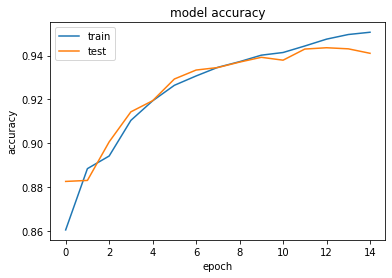

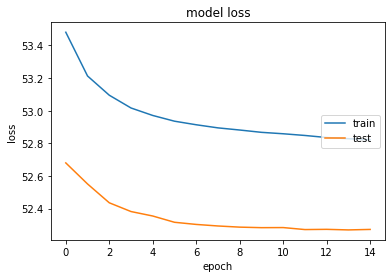

In [21]:

%matplotlib inline
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.subplot(1,1,1)
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()